# CS211: Data Privacy
## Homework 6

In [15]:
# Load the data and libraries
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://github.com/jnear/cs211-data-privacy/raw/master/homework/adult_with_pii.csv')

## Question 1 (10 points)

(Reference [Chapter 7](https://uvm-plaid.github.io/programming-dp/notebooks/ch7.html) of the textbook)

Consider the following minimum query:

In [16]:
## Cache the sorted ages, because we will use them a lot.
age_lower = 0
age_upper = 100
sorted_ages = adult['Age'].clip(lower=age_lower, upper=age_upper).sort_values()
print(sorted_ages)
def min_age():
    clipped_ages = adult['Age'].clip(lower=0, upper=100)
    return clipped_ages.min()

def ls_min():
    return max(sorted_ages.iloc[0] - age_lower, sorted_ages.iloc[1] - sorted_ages.iloc[0])

print('Actual minimum age:', min_age())
print('Local sensitivity of the minimum:', ls_min())

12318    17
6312     17
30927    17
12787    17
25755    17
         ..
24043    90
32277    90
5104     90
8963     90
10210    90
Name: Age, Length: 32561, dtype: int64
Actual minimum age: 17
Local sensitivity of the minimum: 17


Implement `ls_min_at_distance`, an upper bound on the local sensitivity of the `min_age` query at distance $k$, and `dist_to_high_ls_min`, an upper bound on the distance from the true dataset to one with local sensitivity greater than or equal to $s_p$.

In [17]:
def ls_min_at_distance(k):
    if k == 0:
        return 0
    return sorted_ages.iloc[k]

def dist_to_high_ls(f, s_p):
    dist = 0
    while f(dist) < s_p:
        dist += 1

    return dist

def dist_to_high_ls_min(s_p):
    return dist_to_high_ls(ls_min_at_distance, s_p)

In [18]:
# TEST CASE
print(dist_to_high_ls_min(18))
assert dist_to_high_ls_min(18) == 395
assert dist_to_high_ls_min(20) == 1657
assert dist_to_high_ls_min(25) == 5570
assert dist_to_high_ls_min(30) == 9711

395


## Question 2 (10 points)

Implement `ptr_min`, which should use the propose-test-release framework to calculate a differentially private estimate of the minimum age. If the test fails, return `None`.

In [19]:
def ptr_min(s_p, epsilon, delta):

    k = dist_to_high_ls_min(s_p)

    noisy_distance = laplace_mech(k, 1, epsilon)
    threshold = np.log(2/delta)/(2*epsilon)

    if noisy_distance >= threshold:
        return laplace_mech(min(sorted_ages), s_p, epsilon)
    else:
        return None

# proposed sensitivity: 0.05
# epsilon, delta = (1.0, 10^-5)
ptr_min(20, 1.0, 1e-5)

19.788166840299926

In [20]:
# TEST CASE
true_min = min_age()
trials = [ptr_min(20, 0.1, 1e-5) for _ in range(20)]
errors = [pct_error(true_min, t) for t in trials]
print(np.mean(errors))
assert np.mean(errors) < 2000
assert np.mean(errors) > 500

assert ptr_min(0.0001, 0.1, 1e-5) == None

1098.366212375165


## Question 3 (5 points)

In 2-5 sentences, answer the following:

- Can `ptr_mean` give a useful answer for the minimum age?
- If so, what is a good proposed sensitivity $s_p$ for the analyst to use? If not, why not?

No, it gives us an error of about 1000%, which might as well be random noise, (given 1000% of 17 is 170, well outside the range of real ages).
This data is too locally sensitive over the operation of min for it to be obscured practically in this way.


## Question 4 (10 points)

Consider the `median_age` function, which calculates the *median* age (this version truncates if the length of the dataset is even), and the `ls_median` function, an upper bound on the local sensitivity of the median query:

In [21]:
## Cache the sorted ages, because we will use them a lot.
sorted_ages = adult['Age'].clip(lower=0, upper=100).sort_values()

def median_age():
    idx = int(len(adult)/2)
    return sorted_ages.iloc[idx]

print('Median age:', median_age())

def ls_median():
    idx = int(len(adult)/2)
    return max(sorted_ages.iloc[idx] - sorted_ages.iloc[idx-1],
               sorted_ages.iloc[idx+1] - sorted_ages.iloc[idx])

print('Local sensitivity of the median:', ls_median())

Median age: 37
Local sensitivity of the median: 0


Note that the local sensitivity of the median is 0. Implement the functions `ls_median_at_distance`, which calculates the local sensitivity at distance $k$ of the median query above, and the corresponding `dist_to_high_ls_median`.

*Hint*: note that the ages are clipped. Think about the worst-case scenario of adding or removing $k$ rows.

In [27]:
def ls_median_at_distance(k):
    idx = int(len(adult)/2)
    return max(sorted_ages.iloc[idx] - sorted_ages.iloc[idx-k],
               sorted_ages.iloc[idx+k] - sorted_ages.iloc[idx])

def dist_to_high_ls_median(s_p):
    return dist_to_high_ls(ls_median_at_distance, s_p)

ls_median_at_distance(10000)

14

In [28]:
assert ls_median_at_distance(500) == 1
assert ls_median_at_distance(5000) == 6
assert ls_median_at_distance(10000) == 14
assert ls_median_at_distance(15000) == 28

## Question 5 (10 points)

Use the propose-test-release framework, plus `dist_to_high_ls_median`, to answer the median query with differential privacy.

In [33]:
def ptr_median(s_p, epsilon, delta):
    k = dist_to_high_ls_median(s_p)

    noisy_distance = laplace_mech(k, 1, epsilon)
    threshold = np.log(2/delta)/(2*epsilon)

    if noisy_distance >= threshold:
        return laplace_mech(median_age(), s_p, epsilon)
    else:
        return None

ptr_median(0.01, 1.0, 1e-5)

37.00581357749604

In [34]:
# TEST CASE
true_median = median_age()
trials = [ptr_median(0.05, 0.1, 1e-5) for _ in range(20)]
errors = [pct_error(true_median, t) for t in trials]
print(np.mean(errors))
assert np.mean(errors) < 10

1.344276033394174


## Question 6 (10 points)

In 2-5 sentences, answer the following:

- At roughly what distance does the local sensitivity of the median become non-zero?
- For what proposed sensitivity does `ptr_median` fail the test (i.e. return `None`)?
- What does this mean for the amount of noise required to release the median with differential privacy?

IndexError: single positional indexer is out-of-bounds

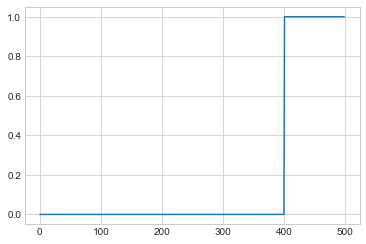

In [48]:
plt.plot([ls_median_at_distance(i) for i in range(500)])
i = 0.05
median = 0
while median is not None:
    median = ptr_median(i, 0.1, 1e-5)
    i -= 0.00001
print(i)

About 400.
I cannot find a positive sensitivity which returns None.
Because the data is very insensitive to change, we do not need to add nearly as much noise to retain differential privacy, because adding or removing people will have a much smaller effect.

## Question 7 (20 points)

Use the sample-and-aggregate framework to release the minimum age in the adult dataset. Reference [Chapter 7](https://uvm-plaid.github.io/programming-dp/notebooks/ch7.html).

In [77]:
def f(chunk):
    return chunk.min()

from random import shuffle

random_ages = sorted_ages.copy()
shuffle(random_ages)

def saa_min_age(k, epsilon):
    # Calculate the number of rows in each chunk

    chunk_size = int(np.ceil(random_ages.shape[0] / k))

    # Step 1: split into chunks
    xs      = [random_ages[i:i+chunk_size] for i in range(0, random_ages.shape[0],chunk_size)]

    # Step 2: run f on each x_i and clip its output
    answers = [f(x_i) for x_i in xs]

    u = 100
    l = 0
    clipped_answers = np.clip(answers, l, u)

    # Step 3: take the noisy min of the answers
    noisy_mean = laplace_mech(np.mean(clipped_answers), 100/k, epsilon)
    return noisy_mean

saa_min_age(500, 1.0)

17.678336087943315

3.752044971362692


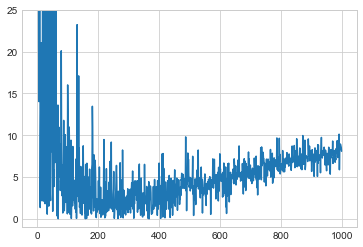

In [82]:
# TEST CASE
true_min = adult['Age'].min()
trials = [saa_min_age(500, 1.0) for _ in range(20)]
errors = [pct_error(true_min, t) for t in trials]
print(np.mean(errors))
assert np.mean(errors) > 0
assert np.mean(errors) < 10

plt.ylim([-1, 25])
plt.plot([pct_error(true_min, saa_min_age(i, 1.0)) for i in range(1,1000)])

## Question 8 (10 points)

In 5-6 sentences, answer the following:

- What clipping values did you choose for clipping the query outputs on each chunk? How did you pick them?
- Is 500 a good value for the number of chunks $k$? How does making $k$ larger or smaller change the results?
- How does the sample-and-aggregate approach compare to propose-test-release or global sensitivity for the minimum?

100 and 0 seem to work just fine for clipping, and i believe the ages were already clipped to this, and further clipping could introduce unnecessary human bias into the sensitivity.

When k is very small, the error is large. When k is very large, it climbs back up. For this dataset, it bottoms out around 250. We can see that 500 is a decent choice but could be a little better.

Much lower error in this particular instance, because there are a large number of 17 year olds in the dataset, so by splitting into chunks, we take advantage of the fact that no individual can be easily identified by the fact that they are 17, and in doing so distribute the burden of privacy cost.


Sorry for the lateness, I've had an emotionally intense couple of weeks.
